In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
%matplotlib inline
#np.set_printoptions(threshold=np.nan)

In [66]:
# crete_random_data(N=number of parties,M=number of communes)
# for each commune, create a random percentage distribution for the list of parties

def create_random_data(N,M):
    ptab = 2 * np.random.rand(N)
    tab = ptab[:,np.newaxis] + np.random.normal(0.0,0.5,(N,M))
    #tab = 1 * np.random.rand(N, M)
    tab = np.exp(tab)
    stab = np.sum(tab, 0)
    tab = tab / stab[None, :]
    return tab

#create_random_pop(M=number of communes)
#for each commune create a random population

def create_random_pop(M):
    #pop = np.random.randint(1000,size=M)
    pop = np.floor((np.random.pareto(1, size=M))*500)
    return pop

#vote(data=table with the percentage of each party for each canton,Nrepr=number of represent to elec for each canton)
#compute the vote to get the number of representants per cantons (check the highest percentage give it a representant,
#substract 1/Nrepr and repeat).

def vote(data,Nrepr):
    repr=np.zeros(data.shape)
    for i in range(Nrepr):
        maxi=np.argmax(data,0)

        k = (maxi[:,None]==np.arange(data.shape[0])).transpose()
        repr = repr + k.astype(int)
        data[k]=data[k]-(1/Nrepr)

    nan_tab = np.isnan(data)
    repr[nan_tab]=0

    return repr

#compute_tab_K(tab=percentage of vote by parties and commune,pop=population of each commune,K_index=canton of each commune)
#aggregate the vote per cantons

def compute_tab_K(tab,pop,K_index,K):
    K_full = (K_index[:, None] == np.arange(K))
    tab_mult_by_pop = pop * tab
    tab_sum = np.matmul(tab_mult_by_pop, K_full.astype(float))
    K_sum = (pop * K_full.transpose()).sum(1)

    final_tab = tab_sum/K_sum
    #nan_tab = np.isnan(final_tab)
    #final_tab[nan_tab]=0

    return final_tab

#reproduce(K_index1=canton for each commune (one repartition),K_index1=canton for each commune (another repartition))
#create a new repartition given two (select randomly one element in each repartition)

def reproduce_K(K_index1,K_index2):
    choice=np.random.randint(2,size=K_index1.shape)
    K_tot=np.stack([K_index1,K_index2],axis=1)
    return(K_tot[choice[:,None]==np.arange(2)])

#mute(K_index=canton per commune (one repartition),prob=probability to mute)
#change to a commune to a random canton with probability prob

def mute_K(K_index,K,prob):
    choice=np.random.randint(K,size=K_index.shape)
    change=(np.random.rand(K_index.shape[0])<prob).astype(int)
    K_tot = np.stack([K_index, choice], axis=1);
    return (K_tot[change[:,None]==np.arange(2)])



def get_new_generation(K_index_list,N_parents,N_child_per_couple,prob,K):

    child_list=[]

    for i in range(N_parents):
        for j in range(i+1,N_parents):
            for k in range(N_child_per_couple):
                child=reproduce_K(K_index_list[i],K_index_list[j])
                child=mute_K(child,K,prob)
                child_list.append(child)
    return child_list


def compute_loss(child_list,tab,pop,N_repr):
    loss=[]
    rloss=[]
    for child in child_list:
        repr=vote(compute_tab_K(tab,pop,child,K),N_repr)
        repr_percent=(repr/(repr.sum().sum())).sum(1)
        rloss.append(np.square(repr_percent-ground_truth).sum())
        loss.append(np.square(repr_percent-ground_truth).sum() + 0.01 * np.linalg.norm((child[:, None] == np.arange(K)).sum(0)-(child[:, None] == np.arange(K)).sum(0).mean()))
    return loss, rloss


In [3]:
#=============== variable generation parameters ===============
N=15 #number of categories (parties)
M=2200 #number of item (communes)
#==============================================================

#=============== model parameters =============================
K=26 #number of cantons
N_repr=2 #number of representant per canton
#==============================================================

#=============== optimization parameters =============
N_parents=10
N_iter=1000
child_per_couple=2
mute_probability=0.04
#=====================================================

In [ ]:
main_tab = create_random_data(N,M)
main_pop = create_random_pop(M)
ground_truth = (main_pop * main_tab).sum(1)/main_pop.sum()

print(main_pop.sum())
print(main_tab.sum().sum())
print(ground_truth)


parent_list = []
for i in range(N_parents):
    parent_list.append(np.random.randint(K,size=M))

minloss=[]
avgloss=[]

for iter in range(N_iter):
    child_list = get_new_generation(parent_list,N_parents,child_per_couple,mute_probability,K)

    loss=np.array(compute_loss(child_list,main_tab,main_pop,N_repr))
    minloss.append(loss.min())
    avgloss.append(loss.mean())
    idx = loss.argsort()[:N_parents]
    parent_list=[child_list[i] for i in idx]


print(minloss[-1])

In [ ]:

plt.plot(np.arange(0,N_iter,1),np.array(minloss))
plt.plot(np.arange(0,N_iter,1),np.array(avgloss))
plt.show()
plt.hist(main_pop,bins=50)
plt.show()

In [4]:
def load_party_data(path):
    data=pd.read_excel(path)
    data.drop([data.columns[0],data.columns[2],data.columns[3],data.columns[4]],1,inplace=True)
    data.drop([0,1],0,inplace=True)
    data.columns=['commune','party','percentage']
    data=data.ffill()
    data=data.groupby(['commune','party']).sum().unstack('party')
    data2=data.reset_index()['percentage']
    data2['commune']=data.reset_index()['commune']
    return data2



In [5]:
#load data
data=load_party_data('data/partis_12prem_vote_2015.xlsx')
data2=load_party_data('data/partis_12der_vote_2015.xlsx')
#take only commune
data=data[data['commune'].str.startswith('......')]
data2=data2[data2['commune'].str.startswith('......')]
data['commune']=data['commune'].str[7:]
data2['commune']=data2['commune'].str[7:]
#merge datasets
data=pd.merge(data,data2,on='commune')
#replace non-available parties with 0
data.loc[:, data.columns != 'commune']=data.loc[:, data.columns != 'commune'].replace('...','0')
#remove data from comming from correspondancies
data=data[(data['commune'].str[:2]==(data['commune'].str.upper()).str[:2]) & (data['commune'].str[2]=='-') ==False]
data.loc[:, data.columns != 'commune']=data.loc[:, data.columns != 'commune']
data=data.set_index('commune')
data.index=data.index.str.replace(re.escape(' (Urne commune)'),'')
data=data.astype(float)
data=data.sort_index()

In [6]:
data_tot=data.as_matrix()
#data_tot=data_tot/data_tot.sum(1)[:,None]
data_tot
data.index.to_series()[data_tot.sum(1)==0]

commune_with_no_vote=(data_tot.sum(1)==0)

data_tot[commune_with_no_vote==False]=np.divide(data_tot[commune_with_no_vote==False],data_tot[commune_with_no_vote==False].sum(1)[:,None])

data_tab=data_tot[commune_with_no_vote==False]


In [7]:
general=pd.read_excel('data/general_2015.xlsx')
general=general[['Unnamed: 1','Unnamed: 9']]
general.drop([0,1],0,inplace=True)
general.columns=['commune','voters']
#general=general[general['commune'].str.startswith('......')]
general=general[general['commune'].str.startswith('......',na=False)]
general['commune']=general['commune'].str[7:]
general=general[(general['commune'].str[:2]==(general['commune'].str.upper()).str[:2]) & (general['commune'].str[2]=='-') ==False]
general['voters']=general['voters'].replace('...','0')
general['voters']=general['voters'].astype(int)
general=general.set_index('commune')
general=general.sort_index()


In [8]:
pop_tot=np.squeeze(general.as_matrix())
pop_tab=pop_tot[commune_with_no_vote==False]
#plt.hist(pop_tab,bins=50)

In [67]:
#=============== model parameters =============================
K=26 #number of cantons
N_repr=2 #number of representant per canton
#==============================================================

#=============== optimization parameters =============
N_parents=15
N_iter=100
child_per_couple=1
mute_probability=0.01
#=====================================================

ground_truth = (pop_tab * np.transpose(data_tab)).sum(1)/pop_tab.sum()

parent_list = []
for i in range(N_parents):
    parent_list.append(np.random.randint(K,size=pop_tab.shape[0]))


minloss=[]
avgloss=[]


minrloss=[]
avgrloss=[]

for iter in range(N_iter):
    child_list = get_new_generation(parent_list,N_parents,child_per_couple,mute_probability,K)
    
    loss,rloss = compute_loss(child_list,np.transpose(data_tab),pop_tab,N_repr)
    loss=np.array(loss)
    rloss=np.array(rloss)
    minloss.append(loss.min())
    avgloss.append(loss.mean())
    minrloss.append(rloss.min())
    avgrloss.append(rloss.mean())
    
    idx = loss.argsort()[:N_parents]
    parent_list=[child_list[i] for i in idx]

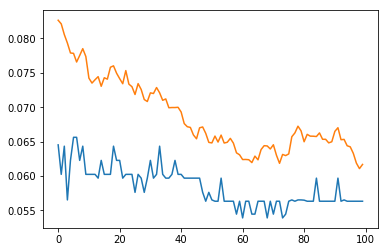

In [68]:

plt.plot(np.arange(0,N_iter,1),np.array(minrloss))
plt.plot(np.arange(0,N_iter,1),np.array(avgrloss))

In [41]:
parent_list[0]
lol=parent_list[0]

In [51]:
np.linalg.norm((lol[:, None] == np.arange(K)).sum(0)-(lol[:, None] == np.arange(K)).sum(0).mean())

43.931765272977593

In [63]:
graph_data=pd.read_csv('graph_commune.csv')
graph_data['municipality']
#graph_data.set_index('municipality',drop=True,inplace=True)
graph_data.columns=['index','neighbors indexes','municipality','neighbors']

In [64]:
common=pd.Series(list(set(data.index).intersection(set(graph_data['municipality']))))
diff1=pd.Series(list(set(data.index)-set(common)))
diff2=pd.Series(list(set(graph_data['municipality'])-set(common)))
diff1

0              Petit-Val
1      Plateau de Diesse
2            Ilanz/Glion
3                  Sauge
4         Péry-La Heutte
5                Calanca
6             Bettmeralp
7               Valbirse
8         Val-de-Charmey
9        Arzier-Le Muids
10            Schinznach
11    Terre di Pedemonte
12               Buchegg
13             Domleschg
14          Albula/Alvra
15         Stocken-Höfen
16              Bussigny
dtype: object

In [65]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(diff2)

0                             Lac de Morat (VD)
1                                Lac Léman (VD)
2                                   Sternenberg
3                                       Paspels
4                                         Duvin
5                                       Besazio
6                                   Hessigkofen
7                                    Cavigliano
8                                      Scheunen
9                               Staatswald Galm
10                                     Sornetan
11                                     Cimadera
12                                       Arzier
13                                   Alvaschein
14                                   Tscheppach
15                                      Pratval
16                        Lac de Neuchâtel (FR)
17                                   Martisberg
18                                     Ruschein
19                                        Luven
20                        Lac de Neuchât

In [71]:
fusion=[['Valbirse','Malleray','Bévilard','Pontenet'],
        ['Terre di Pedemonte','Cavigliano','Tegna','Verscio'],
        ['Val-de-Charmey','Charmey','Cerniat (FR)'],
        ['Sauge','Frinvillier','Plagne','Vauffelin'],
        ['Buchegg','Aetigkofen','Aetingen','Bibern (SO)','Brügglen','Gossliwil','Hessigkofen','Küttigkofen','Kyburg-Buchegg','Mühledorf (SO)','Tscheppach'],
        ['Domleschg','Almens','Paspels','Pratval','Rodels','Tomils'],
        ['Petit-Val','Châtelat','Monible','Sornetan','Souboz'],
        ['Ilanz/Glion','Castrisch','Ilanz','Ladir','Luven','Pitasch','Riein','Ruschein','Schnaus','Sevgein','Duvin','Pigniu','Rueun','Siat'],
        ['Péry-La Heutte','Péry','La Heutte'],
        ['Calanca','Arvigo','Braggio','Cauco','Selma'],
        ['Bettmeralp','Betten','Martisberg'],
        ['Arzier-Le Muids','Arzier'],
        ['Schinznach','Schinznach-Dorf','Oberflachs'],
        ['Albula/Alvra','Alvaschein','Mon','Stierva','Tiefencastel','Alvaneu','Brienz/Brinzauls','Surava'],
        ['Bussigny','Bussigny-près-Lausanne'],
        ['Stocken-Höfen','Niederstocken','Oberstocken','Höfen'],
        ['Plateau de Diesse','Diesse','Lamboing','Prêles'],
        ['Mendrisio','Besazio','Ligornetto','Meride'],
        ['Lugano','Bogno','Cadro','Carona','Certara','Cimadera','Sonvico','Valcolla'],
        ['Bauma','Sternenberg'],
        ['Scuol','Guarda','Ardez','Tarasp','Ftan','Sent'],
        ['Jegenstorf','Scheunen','Münchringen'],
        ['Fraubrunnen','Büren zum Hof','Etzelkofen','Grafenried','Limpach','Mülchi','Schalunen','Zauggenried'],
        ['Murten','Staatswald Galm'],
        ['Grafschaft','Kommunanz Reckingen-Gluringen/Grafschaft'],
        ['Cadenazzo','Comunanza Cadenazzo/Monteceneri'],
        ['Wiesendangen','Bertschikon'],
        ['Innertkirchen','Gadmen'],
        ['Endingen','Unterendingen'],
        ['Uttigen','Kienersrüti'],
        ['Bremgarten (AG)','Bremgarten','Hermetschwil-Staffeln'],
        ['Zernez','Lavin','Susch'],
        ['Oberdiessbach','Bleiken bei Oberdiessbach'],
        ['Vals','St. Martin']
]


In [72]:
graph_data2=graph_data

for elem in fusion:
    graph_data2['municipality'][graph_data['municipality'].isin(elem[1:])]=elem[0]

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [68]:
#print(graph_data2['municipality'])

common=pd.Series(list(set(data.index).intersection(set(graph_data2['municipality']))))
diff1=pd.Series(list(set(data.index)-set(common)))
diff2=pd.Series(list(set(graph_data2['municipality'])-set(common)))
diff1

Series([], dtype: float64)

In [70]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(diff2)

0     Lac de Neuchâtel (NE)
1            Bielersee (NE)
2            Lago di Lugano
3         Lac de Morat (VD)
4            Lac Léman (VD)
5             Bodensee (TG)
6            Bielersee (BE)
7                 Thunersee
8     Lac de Neuchâtel (VD)
9               Brienzersee
10            Lago Maggiore
11    Lac de Neuchâtel (FR)
12               St. Martin
13           Lac Léman (VS)
14            Bodensee (SG)
dtype: object
